In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import os
import sys
from tqdm import tqdm

import torch
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2
from einops import rearrange

from transformers import SegformerForSemanticSegmentation

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# local imports
root_dir = os.path.abspath(os.path.join('..', '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from data_modules import urbansyn
from utils import DiceLoss, MeanIoU
from urbansyn_segformer import UrbanSynSegFormer

Data preparation

In [2]:
# Download the UrbanSyn dataset from the huggingface hub.
# It is 21 GB in size, so it might take several minutes
us = urbansyn.UrbanSynDownloader(os.path.join(root_dir, 'data'))
us.download()

# Downscale the original data by a factor of 4.
# This produces images of size 256x512 for fast training.
# Downscaling may also take a while.
us.downscale(factor=4)

c:\main\repos\semantic_segmentation\data\urbansyn already exists.
c:\main\repos\semantic_segmentation\data\urbansyn_resized\256 already exists.


Taking a look at the train data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333332].


torch.Size([16, 3, 256, 512]) torch.Size([16, 256, 512])


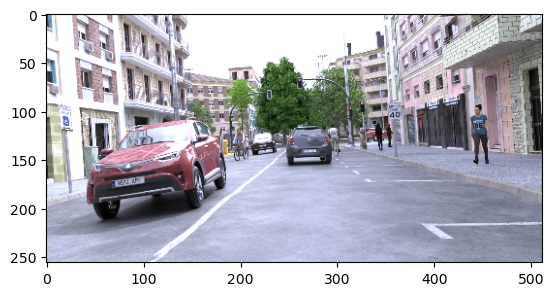

In [3]:
datamodule = us.get_datamodule()
datamodule.setup('fit')
for x, y in datamodule.train_dataloader():
    print(x.size(), y.size())
    plt.imshow(rearrange(urbansyn.INV_NORMALIZE(x[0]), 'c h w -> h w c'))
    break

Finetuning a SegFormer pretrained on Cityscapes

In [3]:
DEBUG = False

LR = 1e-4
LR_GAMMA = 0.99
BATCH_SIZE = 16
IMAGE_DOWNSCALING = 4

LOAD_BEST_CHECKPOINT = False
LOAD_LAST_CHECKPOINT = False
load_version = f'D4_B16_LR0.0001_LRG0.99'

OVERRIDE_HP = False  # if you are loading a checkpoint but want to use the hyperparamaters specified above

version_name = f'D{IMAGE_DOWNSCALING}_B{BATCH_SIZE}_LR{LR}_LRG{LR_GAMMA}'

if LOAD_BEST_CHECKPOINT:
    lightning_model = UrbanSynSegFormer.load_from_checkpoint('best.ckpt')
elif LOAD_LAST_CHECKPOINT:
    lightning_model = UrbanSynSegFormer.load_from_checkpoint(os.path.join('lightning_logs', load_version, 'last.ckpt'))
else:
    lightning_model = UrbanSynSegFormer(learning_rate=LR, lr_gamma=LR_GAMMA)

if OVERRIDE_HP:
    lightning_model.hparams['learning_rate'] = LR
    lightning_model.lr = LR 
    lightning_model.hparams['lr_gamma'] = LR_GAMMA
    lightning_model.lr_gamma = LR_GAMMA

print(lightning_model.hparams)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join('..', '..', 'lightning_logs', version_name),  # Where to save the checkpoints
    filename='{epoch}-{val_loss:.4f}',  # Filename format
    monitor='val_loss',  # Metric to monitor
    save_last=True,  # Always save the last checkpoint
)

logger = TensorBoardLogger('../../', version=version_name)

trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=100),
                             LearningRateMonitor(logging_interval='epoch'),
                             checkpoint_callback],
                  fast_dev_run=DEBUG,
                  max_epochs=500,
                  precision='bf16-mixed',
                  logger=logger,
                 )

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


"learning_rate": 0.0001
"lr_gamma":      0.99


In [6]:
datamodule = us.get_datamodule(batch_size=BATCH_SIZE, downscaling=IMAGE_DOWNSCALING)

In [7]:
trainer.fit(lightning_model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\main\repos\semantic_segmentation\lightning_logs\D4_B16_LR0.0001_LRG0.99 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                             | Params | Mode 
---------------------------------------------------------------------
0 | model   | SegformerForSemanticSegmentation | 3.7 M  | eval 
1 | loss_fn | DiceLoss                         | 0      | train
2 | metrics | MeanIoU                          | 0      | train
----------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Loading a trained model and evaluating it

In [13]:
# specify the desired checkpoint here:
checkpoint_path = 'best.ckpt'
lightning_model = UrbanSynSegFormer.load_from_checkpoint(checkpoint_path)
datamodule = us.get_datamodule(batch_size=16, downscaling=2)
trainer = Trainer()
validation = trainer.validate(lightning_model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │     0.377922922372818     │
│         val_loss          │    0.3614068329334259     │
└───────────────────────────┴───────────────────────────┘

Showing results for a validation batch and a demo image

In [3]:
# specify the desired checkpoint here:
checkpoint_path = 'best.ckpt'
lightning_model = UrbanSynSegFormer.load_from_checkpoint(checkpoint_path)
trainer = Trainer(limit_predict_batches=1)

c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
GPU available: True (cuda), used: True
TPU avail

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050980445..1.1333332].


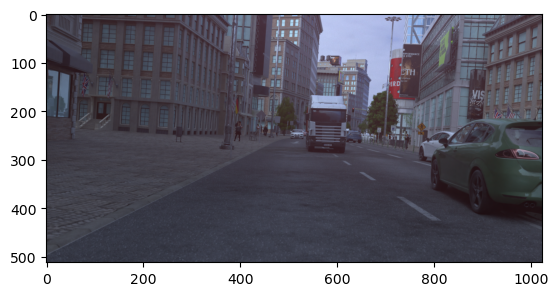

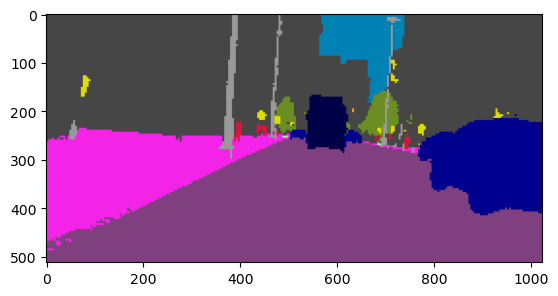

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.054901965..1.1288888].


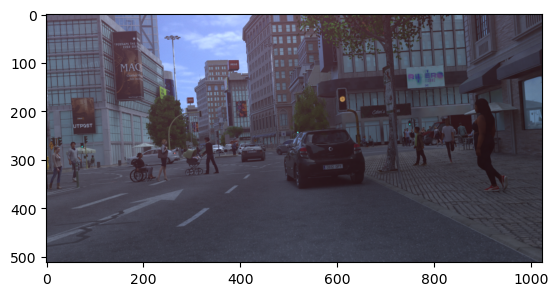

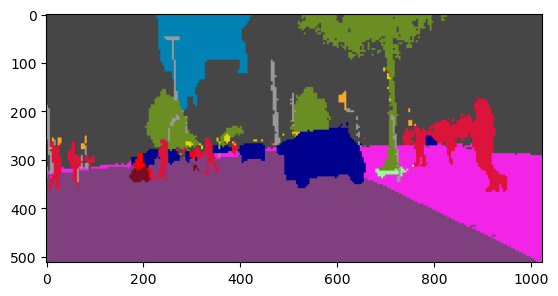

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12156868..1.1333332].


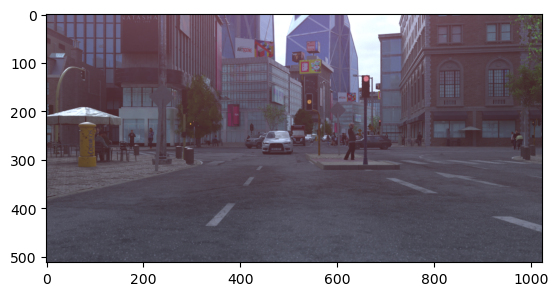

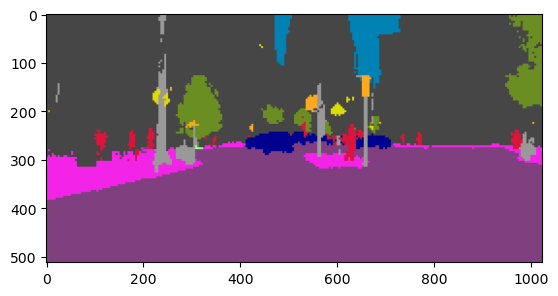

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.054902002..1.1333332].


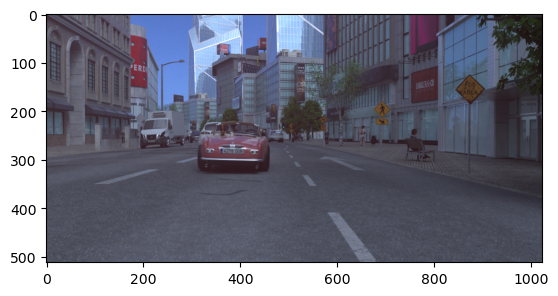

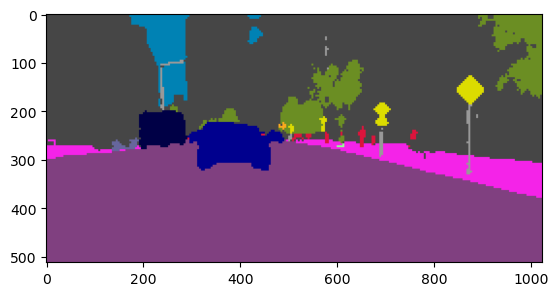

In [5]:
datamodule = us.get_datamodule(batch_size=4, downscaling=2)
datamodule.setup('predict')
batch = next(iter(datamodule.predict_dataloader()))

output = trainer.predict(lightning_model, datamodule=datamodule)[0].detach().cpu()
segmaps = urbansyn.colorize_segmap(torch.argmax(output, 1), for_pil=True)

for image, segmap in zip(batch, segmaps):
    plt.imshow(rearrange(urbansyn.INV_NORMALIZE(image), 'c h w -> h w c'))
    plt.show()
    plt.imshow(segmap)
    plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

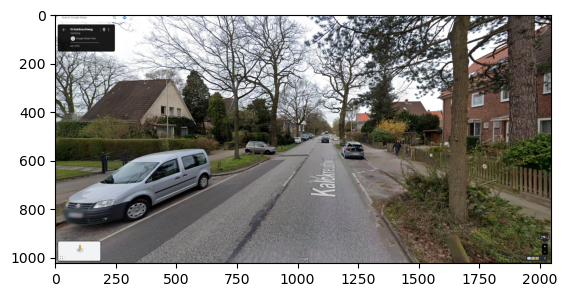

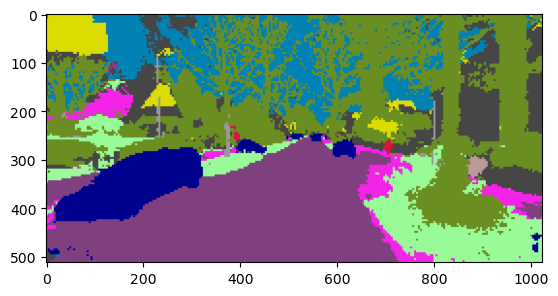

In [6]:
input_path = os.path.join(root_dir, 'data', 'Kalckreuthweg.png')
input = np.array(Image.open(input_path).convert('RGB'))
size = (512, 1024)
transform = A.Compose([A.Resize(*size), A.Normalize(), ToTensorV2()])
x = transform(image=input)['image'].unsqueeze(0).unsqueeze(0)

output = trainer.predict(lightning_model, x)[0].detach().cpu()
segmap = urbansyn.colorize_segmap(torch.argmax(output, 1), for_pil=True)[0]

plt.imshow(input)
plt.show()
plt.imshow(segmap)
plt.show()